In [6]:
!pip install osmnx geopandas
!pip install contextily


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.2/22.2 MB 46.4 MB/s eta 0:00:00


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Data collection

In [3]:
import osmnx as ox
import geopandas as gpd

lsoa_gdf = gpd.read_file("/content/drive/MyDrive/GEOG0105/Research_Area/research_area.shp").to_crs("EPSG:4326")

polygon = lsoa_gdf.geometry.unary_union


/tmp/ipython-input-3-1586271508.py:6: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  polygon = lsoa_gdf.geometry.unary_union


In [4]:
tags = {
    "railway": ["subway_entrance", "station"],
    "highway": "bus_stop",
    "amenity": ["bus_station", "hospital", "police"]
}
poi_gdf = ox.features_from_polygon(polygon, tags=tags)


In [7]:
poi_gdf = ox.features_from_polygon(polygon, tags=tags)

print(poi_gdf['railway'].value_counts(dropna=False))
print(poi_gdf['highway'].value_counts(dropna=False))
print(poi_gdf['amenity'].value_counts(dropna=False))

railway
NaN                438
subway_entrance    139
station             45
Name: count, dtype: int64
highway
bus_stop    403
NaN         218
elevator      1
Name: count, dtype: int64
amenity
NaN            587
hospital        27
police           7
bus_station      1
Name: count, dtype: int64


# Layout

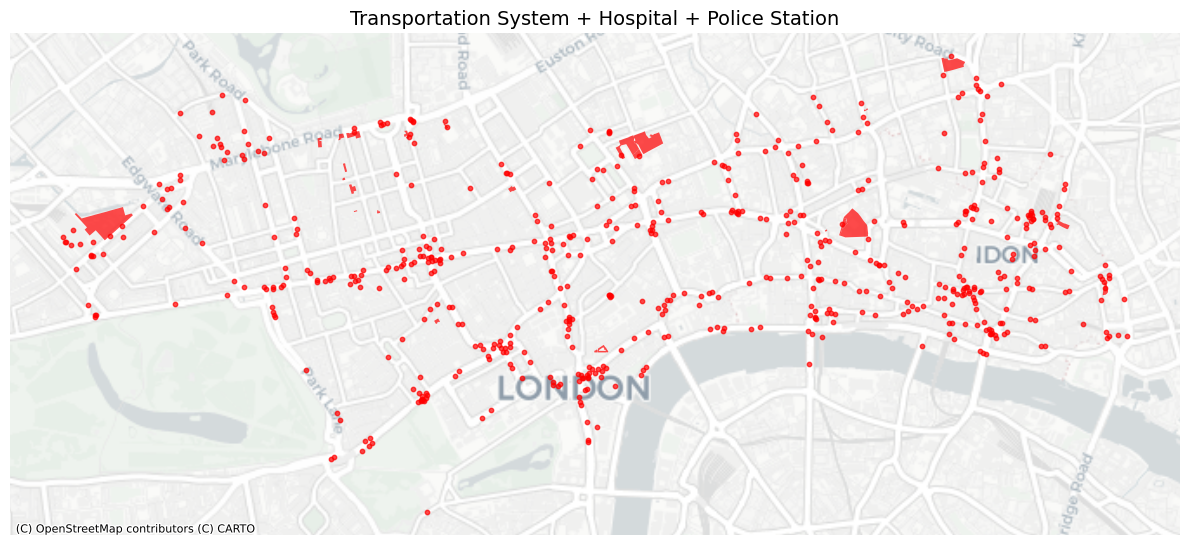

In [9]:
import contextily as ctx
import matplotlib.pyplot as plt

poi_gdf_web = poi_gdf.to_crs(epsg=3857)

fig, ax = plt.subplots(figsize=(12, 12))

poi_gdf_web.plot(ax=ax, markersize=10, alpha=0.7, color='red')

ctx.add_basemap(ax, source=ctx.providers.CartoDB.Positron)

plt.title("Transportation System + Hospital + Police Station", fontsize=14)
plt.axis("off")
plt.tight_layout()
plt.show()



/tmp/ipython-input-11-750654410.py:35: UserWarning: Legend does not support handles for PatchCollection instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  plt.legend(loc="lower left", fontsize=10)


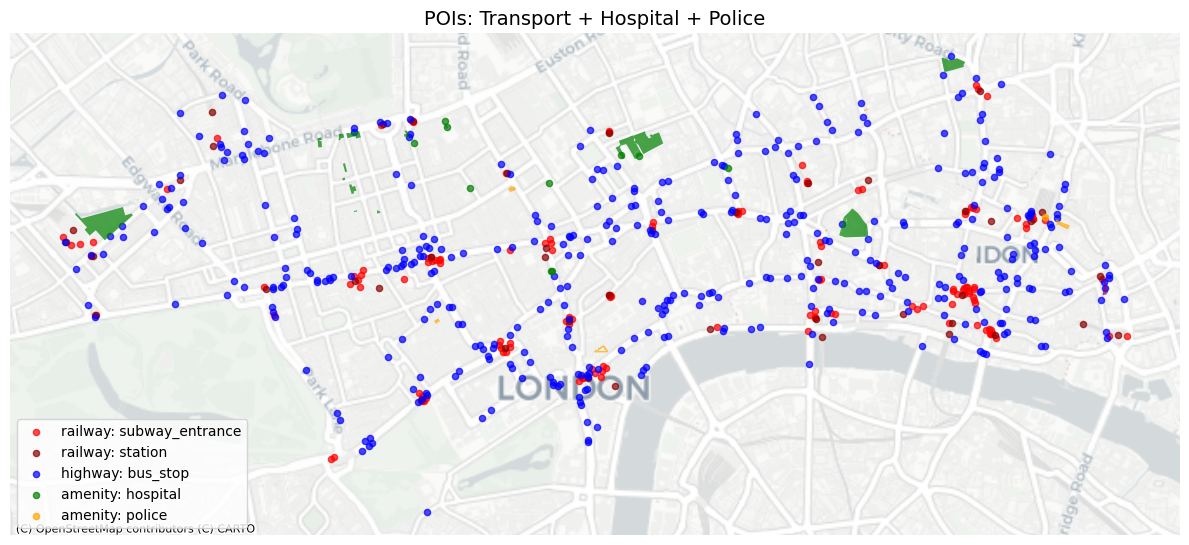

In [11]:
import matplotlib.pyplot as plt
import contextily as ctx

poi_gdf_web = poi_gdf.to_crs(epsg=3857)

category_colors = {
    "subway_entrance": "red",
    "station": "darkred",
    "bus_stop": "blue",
    "bus_station": "purple",
    "hospital": "green",
    "police": "orange"
}

fig, ax = plt.subplots(figsize=(12, 12))

# railway
for val in ["subway_entrance", "station"]:
    sub = poi_gdf_web[poi_gdf_web["railway"] == val]
    sub.plot(ax=ax, markersize=20, color=category_colors[val], label=f"railway: {val}", alpha=0.7)

# highway
sub = poi_gdf_web[poi_gdf_web["highway"] == "bus_stop"]
sub.plot(ax=ax, markersize=20, color=category_colors["bus_stop"], label="highway: bus_stop", alpha=0.7)

# amenity
for val in ["bus_station", "hospital", "police"]:
    sub = poi_gdf_web[poi_gdf_web["amenity"] == val]
    sub.plot(ax=ax, markersize=20, color=category_colors[val], label=f"amenity: {val}", alpha=0.7)

ctx.add_basemap(ax, source=ctx.providers.CartoDB.Positron)

plt.title("POIs: Transport + Hospital + Police", fontsize=14)
plt.axis("off")
plt.legend(loc="lower left", fontsize=10)
plt.tight_layout()
plt.show()


# Calculates public transport station density (bus stops, rail stations) per LSOA.

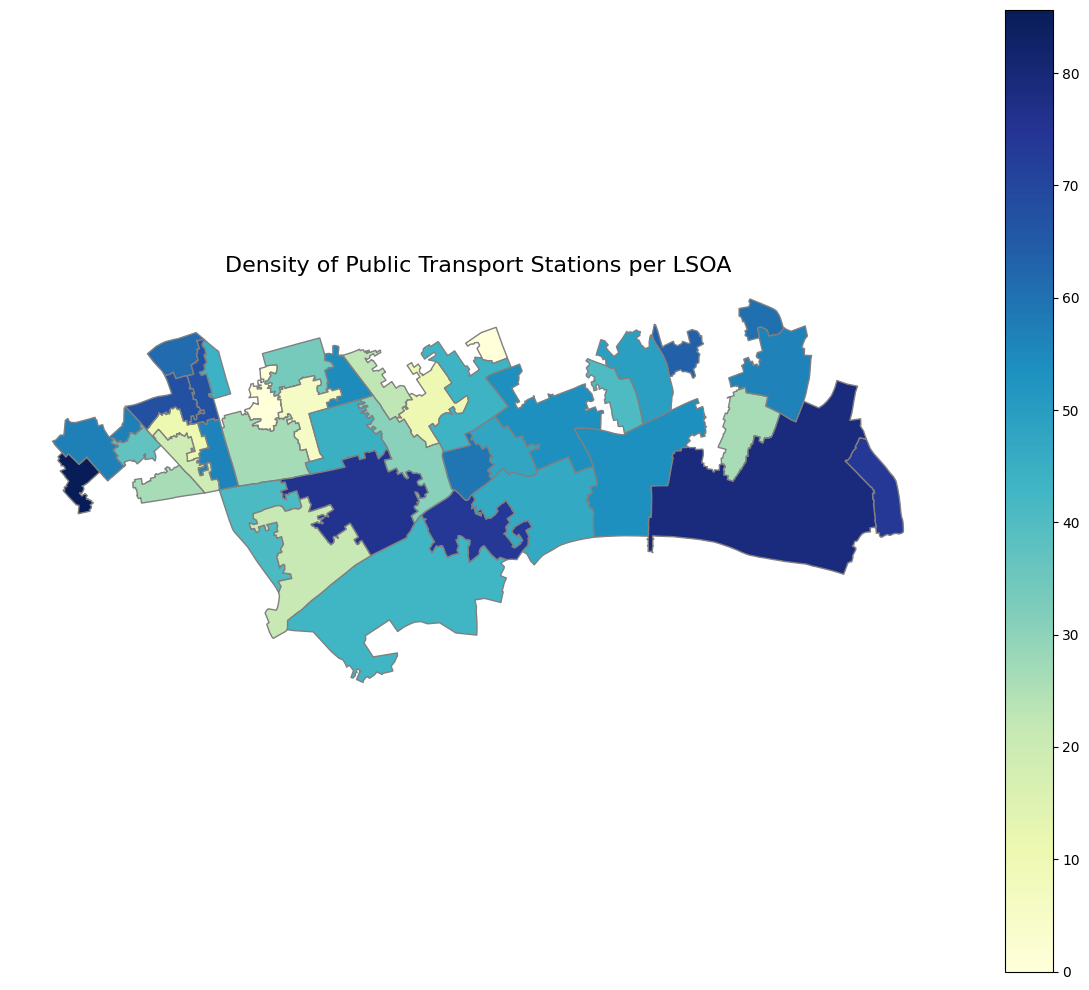

In [12]:
import geopandas as gpd
import osmnx as ox
import matplotlib.pyplot as plt

tags = {
    "railway": ["station", "subway_entrance"],
    "highway": "bus_stop"
}
poi_gdf = ox.features_from_polygon(polygon, tags=tags)

poi_gdf = poi_gdf.set_crs("EPSG:4326")
lsoa_gdf = lsoa_gdf.set_crs("EPSG:4326")

transport_pois = poi_gdf[
    (poi_gdf['highway'] == 'bus_stop') |
    (poi_gdf['railway'].isin(['station', 'subway_entrance']))
].copy()
transport_pois = transport_pois[transport_pois.geometry.notnull()]
transport_pois = transport_pois.set_geometry("geometry")

joined = gpd.sjoin(transport_pois, lsoa_gdf, how="inner", predicate="within")
station_counts = joined.groupby("lsoa21cd").size().reset_index(name="station_count")

lsoa_with_counts = lsoa_gdf.merge(station_counts, on="lsoa21cd", how="left")
lsoa_with_counts["station_count"] = lsoa_with_counts["station_count"].fillna(0)

lsoa_with_counts = lsoa_with_counts.to_crs(epsg=27700)
lsoa_with_counts["area_km2"] = lsoa_with_counts.geometry.area / 1e6
lsoa_with_counts["station_density"] = lsoa_with_counts["station_count"] / lsoa_with_counts["area_km2"]
lsoa_with_counts = lsoa_with_counts.to_crs("EPSG:4326")

fig, ax = plt.subplots(figsize=(12, 10))
lsoa_with_counts.plot(column="station_density", cmap="YlGnBu", legend=True, ax=ax, edgecolor="grey")
plt.title("Density of Public Transport Stations per LSOA", fontsize=16)
plt.axis("off")
plt.tight_layout()
plt.show()



# Calculates the proportion of each LSOA area covered by a 15-minute wheelchair buffer from hospitals and police stations.

/tmp/ipython-input-16-2304946090.py:22: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  buffer_union = facility_gdf["buffer"].unary_union


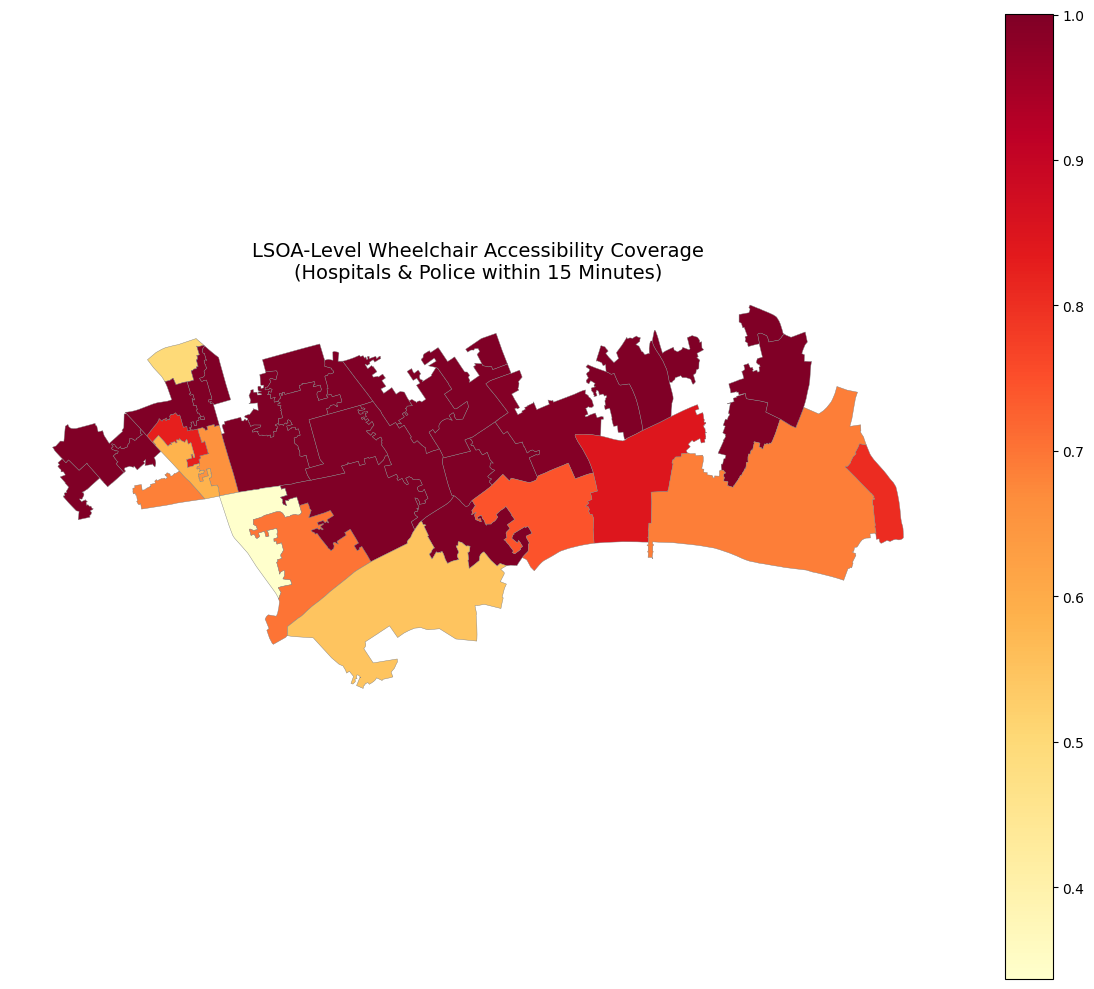

In [16]:
import geopandas as gpd
import osmnx as ox
from shapely.geometry import Point
import matplotlib.pyplot as plt


tags = {
    "amenity": ["hospital", "police"]
}
facility_gdf = ox.features_from_polygon(polygon, tags=tags)

facility_gdf = facility_gdf[facility_gdf.geometry.notnull()].copy()
facility_gdf = facility_gdf.set_geometry("geometry").set_crs("EPSG:4326")

facility_gdf = facility_gdf.to_crs(epsg=27700)
lsoa_with_counts = lsoa_with_counts.to_crs(epsg=27700)

wheelchair_speed_mps = 0.79
radius_m = wheelchair_speed_mps * 60 * 15

facility_gdf["buffer"] = facility_gdf.geometry.buffer(radius_m)
buffer_union = facility_gdf["buffer"].unary_union

lsoa_with_counts["accessible_area"] = lsoa_with_counts.geometry.intersection(buffer_union).area / 1e6
lsoa_with_counts["accessibility_coverage"] = lsoa_with_counts["accessible_area"] / lsoa_with_counts["area_km2"]

lsoa_with_counts = lsoa_with_counts.to_crs("EPSG:4326")

fig, ax = plt.subplots(figsize=(12, 10))
lsoa_with_counts.plot(
    column="accessibility_coverage",
    cmap="YlOrRd",
    legend=True,
    edgecolor="grey",
    linewidth=0.3,
    ax=ax
)
plt.title("LSOA-Level Wheelchair Accessibility Coverage\n(Hospitals & Police within 15 Minutes)", fontsize=14)
plt.axis("off")
plt.tight_layout()
plt.show()




# Calculates pedestrian footway density (in km/km²) for each LSOA based on OSM footway data.

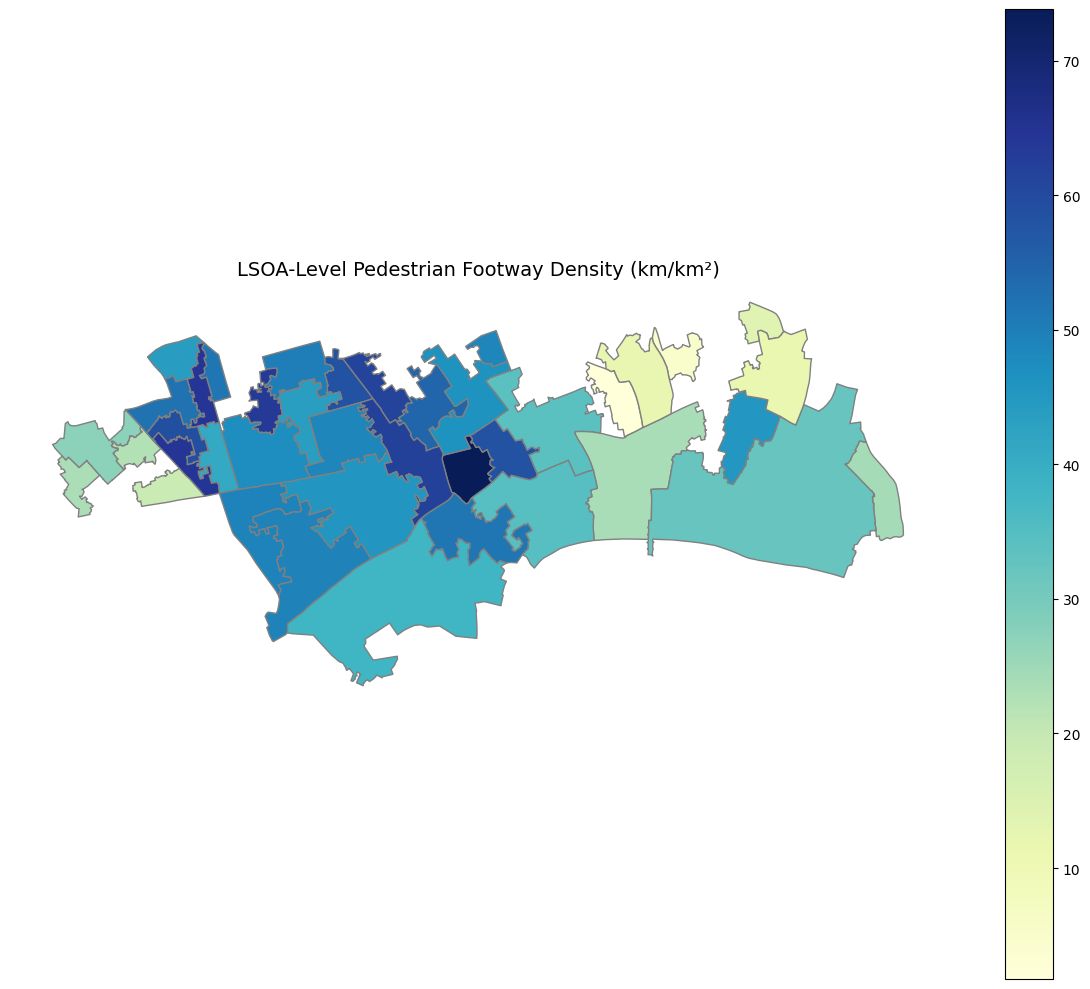

In [18]:
import osmnx as ox
import geopandas as gpd
import matplotlib.pyplot as plt


tags = {"highway": "footway"}
footway_gdf = ox.features_from_polygon(polygon, tags=tags)

footway_gdf = footway_gdf[footway_gdf.geometry.notnull()].copy()
footway_gdf = footway_gdf.set_geometry("geometry").set_crs("EPSG:4326")

footway_gdf = footway_gdf.to_crs(epsg=27700)
lsoa_with_counts = lsoa_with_counts.to_crs(epsg=27700)

footway_lsoa = gpd.sjoin(footway_gdf, lsoa_with_counts, how="inner", predicate="intersects")
footway_lsoa["length_km"] = footway_lsoa.geometry.length / 1000

length_by_lsoa = footway_lsoa.groupby("lsoa21cd")["length_km"].sum().reset_index()

lsoa_with_counts = lsoa_with_counts.merge(length_by_lsoa, on="lsoa21cd", how="left")
lsoa_with_counts["length_km"] = lsoa_with_counts["length_km"].fillna(0)
lsoa_with_counts["footway_density"] = lsoa_with_counts["length_km"] / lsoa_with_counts["area_km2"]

lsoa_with_counts = lsoa_with_counts.to_crs("EPSG:4326")

fig, ax = plt.subplots(figsize=(12, 10))
lsoa_with_counts.plot(
    column="footway_density",
    cmap="YlGnBu",
    legend=True,
    ax=ax,
    edgecolor="grey"
)
plt.title("LSOA-Level Pedestrian Footway Density (km/km²)", fontsize=14)
plt.axis("off")
plt.tight_layout()
plt.show()



#Output for a table

In [20]:
output_df = lsoa_with_counts[[
    "lsoa21cd",
    "area_km2",
    "station_count",
    "station_density",
    "accessibility_coverage",
    "length_km",
    "footway_density"
]]

output_df.to_csv("/content/drive/MyDrive/GEOG0105/lsoa_combined_all_variables.csv", index=False)


In [21]:
output_df

,lsoa21cd,area_km2,station_count,station_density,accessibility_coverage,length_km,footway_density
0,E01000853,0.058568,0.0,0.000000,1.000000,2.842895,48.539987
1,E01000919,0.152825,9.0,58.890963,1.000000,11.287188,73.857041
2,E01000916,0.147250,6.0,40.746936,1.000000,0.257528,1.748912
3,E01000918,0.168256,8.0,47.546538,0.999069,9.800552,58.247791
4,E01000851,0.133424,3.0,22.484688,1.000000,8.209998,61.533083
5,E01000850,0.195157,2.0,10.248133,1.000000,10.654691,54.595346
6,E01000855,0.320524,14.0,43.678510,1.000000,14.853024,46.339853
7,E01000914,0.448043,24.0,53.566276,0.992803,15.183620,33.888750
8,E01000005,0.189578,14.0,73.848344,0.803280,4.579861,24.158223
9,E01000002,0.228420,6.0,26.267427,1.000000,10.319490,45.177744
